In [74]:
import pickle
from pathlib import Path

pickle_path = Path("/scratch/repos/P3PO/p3po/exp_local/eval/11.10.14.45_eval/eval_history.pkl")
with open(pickle_path, "rb") as f:
    data_dict = pickle.load(f)

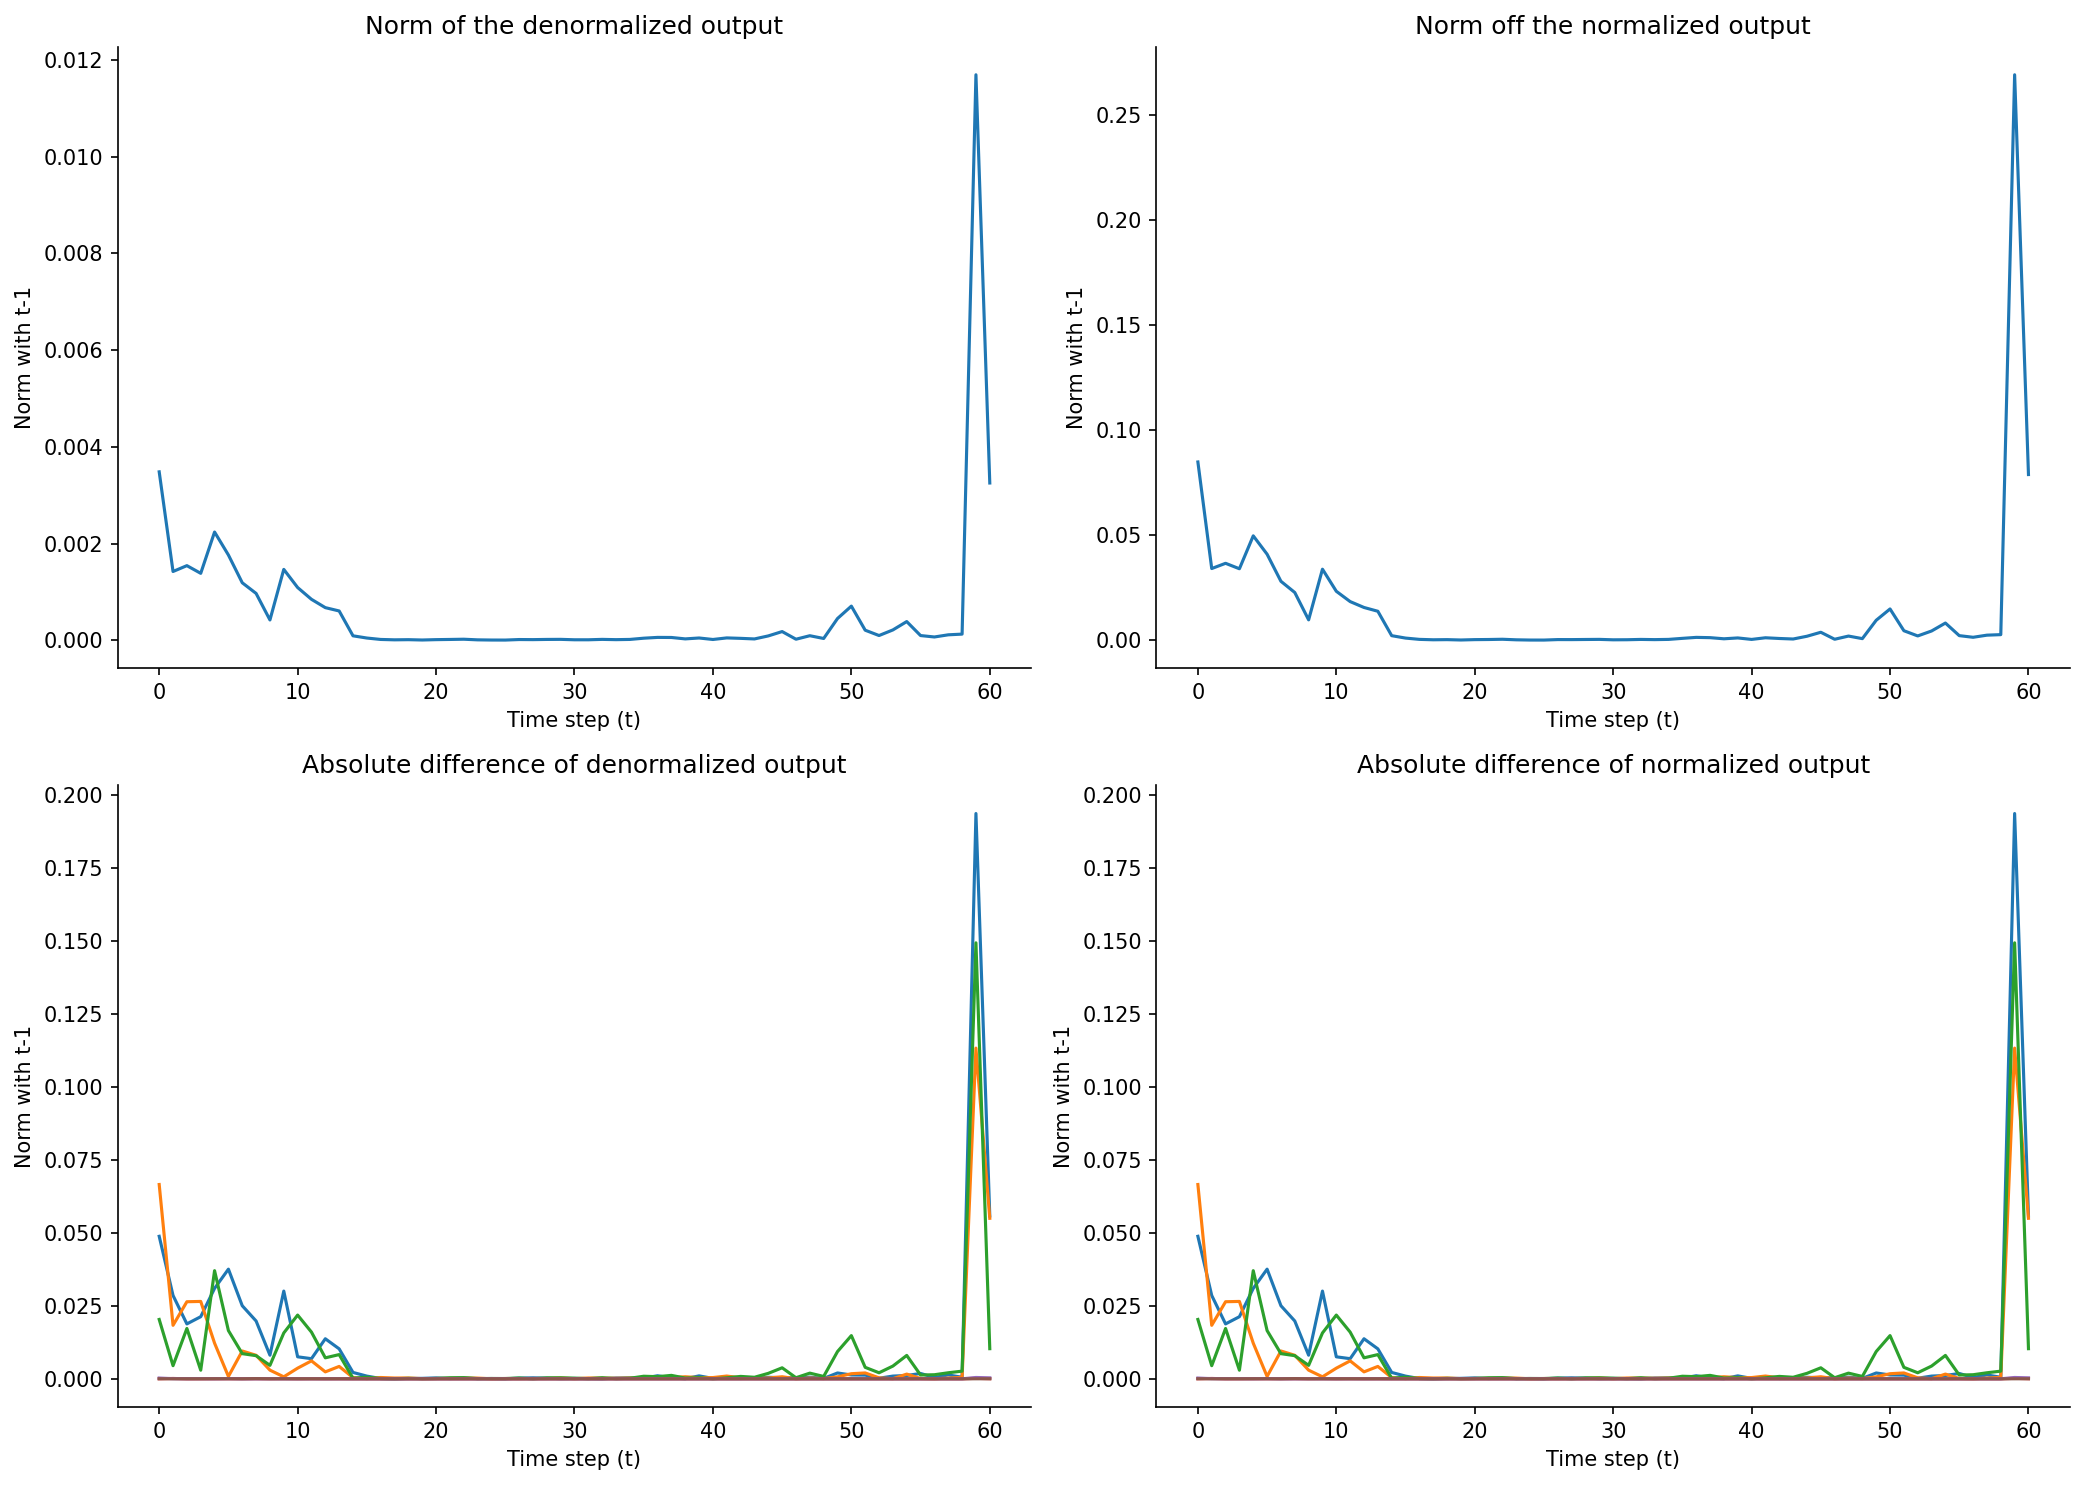

In [73]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(4, suppress=True)

data_dict[0]["obs"].keys() # dict_keys(['features', 'pixels', 'task_emb', 'goal_achieved', 'depth', 'graph'])
data_dict[0]["action"].shape # [1,7]
data_dict[0]["post_processed_action"].shape # 7

norms_denormalized = []
norms_normalized = []

absolut_diffs_normalized = []
absolut_diffs_denormalized = []

prev_normalized = data_dict[0]["action"].reshape(7).cpu().numpy()
prev_denormalized = data_dict[0]["post_processed_action"]

for i in range(1, len(data_dict)):
    graph = data_dict[i]["obs"]["graph"].reshape((-1, 3)).cpu().numpy()
    normalized = data_dict[i]["action"].reshape(7).cpu().numpy()
    denormalized = data_dict[i]["post_processed_action"]

    norms_normalized.append(np.linalg.norm(normalized - prev_normalized))
    norms_denormalized.append(np.linalg.norm(denormalized - prev_denormalized))

    absolut_diffs_normalized.append(np.abs(normalized - prev_normalized)[:6])
    absolut_diffs_denormalized.append(np.abs(denormalized - prev_denormalized)[:6])

    prev_normalized = normalized
    prev_denormalized = denormalized



fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(14, 10))

ax1[0].plot(norms_denormalized, label="Denormalized")
ax1[0].set_title("Norm of the denormalized output")
ax1[0].set_xlabel("Time step (t)")
ax1[0].set_ylabel("Norm with t-1")

ax1[1].plot(norms_normalized, label="Normalized")
ax1[1].set_title("Norm off the normalized output")
ax1[1].set_xlabel("Time step (t)")
ax1[1].set_ylabel("Norm with t-1")


ax2[0].plot(absolut_diffs_normalized, label="Denormalized")
ax2[0].set_title("Absolute difference of denormalized output")
ax2[0].set_xlabel("Time step (t)")
ax2[0].set_ylabel("Norm with t-1")

ax2[1].plot(absolut_diffs_normalized, label="Normalized")
ax2[1].set_title("Absolute difference of normalized output")
ax2[1].set_xlabel("Time step (t)")
ax2[1].set_ylabel("Norm with t-1")


plt.tight_layout()
plt.show()

In [75]:
training_data_path = "/scratch/data/open_teach/processed_data_pkl/put_tennis_ball_in_plate.pkl"

with open(training_data_path, "rb") as f:
    training_data = pickle.load(f)

In [86]:
import imageio

training_data.keys() # ['observations', 'max_cartesian', 'min_cartesian', 'max_gripper', 'min_gripper', 'task_emb']

demo_num = 70

max_cartesian = training_data['max_cartesian']
min_cartesian = training_data['min_cartesian']
max_gripper = training_data['max_gripper']
min_gripper = training_data['min_gripper']

print(f"max_cartesian: {max_cartesian}\nmin_cartesian: {min_cartesian}")
len(training_data['observations']) # 100

training_data['observations'][demo_num].keys() # ['demo_dir', 'pixels0', 'cartesian_states', 'gripper_states']

cartesian_states = training_data['observations'][demo_num]['cartesian_states']
gripper_states = training_data['observations'][demo_num]['gripper_states']

frames = training_data['observations'][demo_num]['pixels0'][..., ::-1]
video_path = Path(f"~/Downloads/demo_{demo_num}.mp4")
video_path.parent.mkdir(parents=True, exist_ok=True)
imageio.mimsave(video_path, frames, fps=30)

max_cartesian: [ 0.3753 -0.2879  0.3227  0.0065 -3.1203  0.0025]
min_cartesian: [-0.1852 -0.7191  0.0822  0.0041 -3.1325 -0.0069]


## Replay from Dataset sampled data

In [1]:
# preprocess the actions
from p3po.read_data.p3po_xarm import BCDataset, get_relative_action, get_quaternion_orientation

path = "/scratch/data/open_teach/processed_data_pkl"
processed_path = "./processed_data"
tasks = ["put_tennis_ball_in_plate"]
num_demos_per_task = 100
obs_type = "features"
history = True
history_len = 10
prompt =  "text"
temporal_agg = True
num_queries = 10
img_size = 128 # should not matter
action_after_steps = 1
intermediate_goal_step = 30
store_actions = True
training_keys = ["graph"]
subsample = 1
skip_first_n = 0
relative_actions = True

dataset = BCDataset(
    path=path,
    processed_path=processed_path,
    tasks=tasks,
    num_demos_per_task=num_demos_per_task,
    obs_type=obs_type,
    history=history,
    history_len=history_len,
    prompt=prompt,
    temporal_agg=temporal_agg,
    num_queries=num_queries,
    img_size=img_size,
    action_after_steps=action_after_steps,
    intermediate_goal_step=intermediate_goal_step,
    store_actions=store_actions,
    training_keys=training_keys,
    subsample=subsample,
    skip_first_n=skip_first_n,
    relative_actions=relative_actions
)

Loading /scratch/data/open_teach/processed_data_pkl/put_tennis_ball_in_plate.pkl


In [3]:
from dm_env import specs
import pickle
import numpy as np

action_spec = specs.BoundedArray(
    (dataset._max_action_dim,),
    np.float32,
    dataset.stats["actions"]["min"],
    dataset.stats["actions"]["max"],
    "action",
)

pickle.dump(action_spec, open("/scratch/repos/P3PO/p3po/exp_local/new_100_data_no_subsampling_use_dataset_stats/11.10.20.11_train/action_spec.pkl", "wb"))

In [ ]:
from p3po.replay_buffer import make_expert_replay_loader

batch_size=1 # actual training used 64
expert_replay_loader = make_expert_replay_loader(dataset, batch_size=batch_size)
sample = next(iter(expert_replay_loader))
stats = expert_replay_loader.dataset.stats # stats passed to agent act function

AttributeError: 'BCDataset' object has no attribute 'sample'

In [ ]:
from playback_demo import run_absolute
from rvkit.control import Robot


robot = Robot()

run_absolute(cartesian_states, gripper_states, robot)

TCP offset set to 0.1734126403712062. This is based on the z offset of the gripper. Please check if this is correct.
Gripper auto-calibrated to [3, 227]
